<a href='https://github.com/muddie9/rockphysics_MAK'>
    <img src= 'https://user-images.githubusercontent.com/50207393/57354680-68ca3600-716c-11e9-8bf3-3054c7eec0ab.png' ,width=200,height= 200 ></a>

Source: https://github.com/seg/tutorials-2014/blob/master/1412_Tuning_and_AVO/tuning_prestack_v2.py

3.0

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import math

###########################################################
#       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [2500.0, 2600.0, 2550.0, 2300.0]  # P-wave velocity (m/s)
vs_mod = [1200.0, 1300.0, 1200.0, 1100.0]  # S-wave velocity (m/s)
rho_mod= [1.95, 2.0, 1.98, 2.1]         # Density (g/cc)

thickness = [15.0, 100.0]  # vertical thickness of layer 2 in metres

#   Angle range for incident rays
theta1_min = 0.0    # best to leave this set to zero
theta1_max = 40.0
theta1_step= 1.0


#   Wavelet Parameters
wvlt_type = 'bandpass'  # Valid values: 'ricker' or 'bandpass'
wvlt_length= 0.128 # Wavelet length in seconds
wvlt_phase = 0.0   # Wavelet phase in degrees
wvlt_scalar = 1.0  # Multiplier to scale wavelet amplitude (default = 1.0)
wvlt_cfreq = 30.0  # Ricker wavelet central frequency
f1 =  5.0          # Bandpass wavelet low truncation frequency
f2 = 10.0          # Bandpass wavelet low cut frequency
f3 = 50.0          # Bandpass wavelet high cut frequency
f4 = 65.0          # Bandpass wavelet high truncation frequency


#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality


#   Plotting Display Parameters
min_plot_time = 0.15
max_plot_time = 0.3
excursion = 2

### Function Definitions:

In [137]:
def plot_vawig(axhdl, data, t, excursion):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape
    

    
    
    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i,:] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        axhdl.plot(tbuf, t, color='black', linewidth=0.5)
        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[0.6,0.6,1.0], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[1.0,0.7,0.7], linewidth=0)
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
    t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def wvlt_bpass(f1, f2, f3, f4, phase, dt, wvlt_length):
    '''
    Calculate a trapezoidal bandpass wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(f1, f2, f3, f4, phase, dt, wvlt_length)
    
    f1: Low truncation frequency of wavelet in Hz
    f2: Low cut frequency of wavelet in Hz
    f3: High cut frequency of wavelet in Hz
    f4: High truncation frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    from numpy.fft import fft, ifft, fftfreq, fftshift, ifftshift
    
    nsamp = int(wvlt_length/dt + 1)
    
    
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    aspec = freq*0.0
    pspec = freq*0.0
    
    # Calculate slope and y-int for low frequency ramp
    M1 = 1/(f2-f1)
    b1 = -M1*f1
    
    # Calculate slop and y-int for high frequency ramp
    M2 = -1/(f4-f3)
    b2 = -M2*f4
    
    # Build initial frequency and filter arrays
    freq = fftfreq(nsamp, dt)
    freq = fftshift(freq)
    filt = np.zeros(nsamp)
    
    # Build LF ramp
    idx = np.nonzero((np.abs(freq)>=f1) & (np.abs(freq)<f2))
    filt[idx] = M1*np.abs(freq)[idx]+b1
    
    # Build central filter flat
    idx = np.nonzero((np.abs(freq)>=f2) & (np.abs(freq)<=f3))
    filt[idx] = 1.0
    
    # Build HF ramp
    idx = np.nonzero((np.abs(freq)>f3) & (np.abs(freq)<=f4))
    filt[idx] = M2*np.abs(freq)[idx]+b2
    
    # Unshift the frequencies and convert filter to fourier coefficients
    filt2 = ifftshift(filt)
    Af = filt2*np.exp(np.zeros(filt2.shape)*1j)
    
    # Convert filter to time-domain wavelet
    wvlt = fftshift(ifft(Af))
    wvlt = np.real(wvlt)
    wvlt = wvlt/np.max(np.abs(wvlt)) # normalize wavelet by peak amplitude

    # Generate array of wavelet times
    t = np.linspace(-wvlt_length*0.5, wvlt_length*0.5, nsamp)
    
    
    # Apply phase rotation if desired
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt
    
    

def calc_times(z_int, vp_mod):
    '''
    Calculate two-way travel time through a layered model
    
    Usage:
    -----
    t_int = calc_times(z_int, vp_mod)
    
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            zdiff = zdiff*2.0   # multiply by 2 for two-way traveltimes
            tbuf = zdiff/vp_mod[i] + t_int[i-1]
            tbuf = tbuf
            t_int.append(tbuf)
    
    return t_int

In [138]:
z_int

[500.0, 515.0, 615.0]

In [139]:
def digitize_model(rc_int, t_int, t):
    '''
    Sample a simple layered reflectivity model
    
    Usage:
    ------
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc
    

def rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1):
    '''
    Reflection & Transmission coefficients calculated using full Zoeppritz
    equations.
    
    Usage:
    ------
    R = rc_zoep(vp1, vs1, rho1, vp2, vs2, rho2, theta1)
    
    Reference:
    ----------
    The Rock Physics Handbook, Dvorkin et al.
    '''
    
    import math
    
    # Cast inputs to floats
    vp1  = float(vp1)
    vp2  = float(vp2)
    vs1  = float(vs1)
    vs2  = float(vs2)
    rho1 = float(rho1)
    rho2 = float(rho2)
    theta1 = float(theta1)
    
    # Calculate reflection & transmission angles
    theta1 = math.radians(theta1)   # Convert theta1 to radians
    p      = ray_param(vp1, math.degrees(theta1)) # Ray parameter
    theta2 = math.asin(p*vp2);      # Transmission angle of P-wave
    phi1   = math.asin(p*vs1);      # Reflection angle of converted S-wave
    phi2   = math.asin(p*vs2);      # Transmission angle of converted S-wave
    
    # Matrix form of Zoeppritz Equations... M & N are two of the matricies
    M = np.array([ \
        [-math.sin(theta1), -math.cos(phi1), math.sin(theta2), math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [-rho1*vp1*(1-2*math.sin(phi1)**2), rho1*vs1*math.sin(2*phi1), \
            rho2*vp2*(1-2*math.sin(phi2)**2), -rho2*vs2*math.sin(2*phi2)]
        ], dtype='float')
    
    N = np.array([ \
        [math.sin(theta1), math.cos(phi1), -math.sin(theta2), -math.cos(phi2)],\
        [math.cos(theta1), -math.sin(phi1), math.cos(theta2), -math.sin(phi2)],\
        [2*rho1*vs1*math.sin(phi1)*math.cos(theta1), rho1*vs1*(1-2*math.sin(phi1)**2),\
            2*rho2*vs2*math.sin(phi2)*math.cos(theta2), rho2*vs2*(1-2*math.sin(phi2)**2)],\
        [rho1*vp1*(1-2*math.sin(phi1)**2), -rho1*vs1*math.sin(2*phi1),\
            -rho2*vp2*(1-2*math.sin(phi2)**2), rho2*vs2*math.sin(2*phi2)]\
        ], dtype='float')
    
    # This is the important step, calculating coefficients for all modes and rays
    R = np.dot(np.linalg.inv(M), N);
    
    return R


def ray_param(v, theta):
    '''
    Calculates the ray parameter p
    
    Usage:
    ------
        p = ray_param(v, theta)
    
    Inputs:
    -------
            v = interval velocity
        theta = incidence angle of ray (degrees)
    
    Output:
    -------
        p = ray parameter (i.e. sin(theta)/v )
    '''
    
    import math
    
    # Cast inputs to floats
    theta = float(theta)
    v = float(v)
    
    p = math.sin(math.radians(theta))/v # ray parameter calculation
    
    return p
    
    

### Computations:



Starting synthetic calcuations...

Calculated angle 0
Calculated angle 1
Calculated angle 2
Calculated angle 3
Calculated angle 4
Calculated angle 5
Calculated angle 6
Calculated angle 7
Calculated angle 8
Calculated angle 9
Calculated angle 10
Calculated angle 11
Calculated angle 12
Calculated angle 13
Calculated angle 14
Calculated angle 15
Calculated angle 16
Calculated angle 17
Calculated angle 18
Calculated angle 19
Calculated angle 20
Calculated angle 21
Calculated angle 22
Calculated angle 23
Calculated angle 24
Calculated angle 25
Calculated angle 26
Calculated angle 27
Calculated angle 28
Calculated angle 29
Calculated angle 30
Calculated angle 31
Calculated angle 32
Calculated angle 33
Calculated angle 34
Calculated angle 35
Calculated angle 36
Calculated angle 37
Calculated angle 38
Calculated angle 39
Calculated angle 40



  Method       NI         GRAD
---------------------------------
 Zoeppritz    0.03168    -0.05671
 Convolved   0.03685    -0.08041


TypeError: must be real number, not list

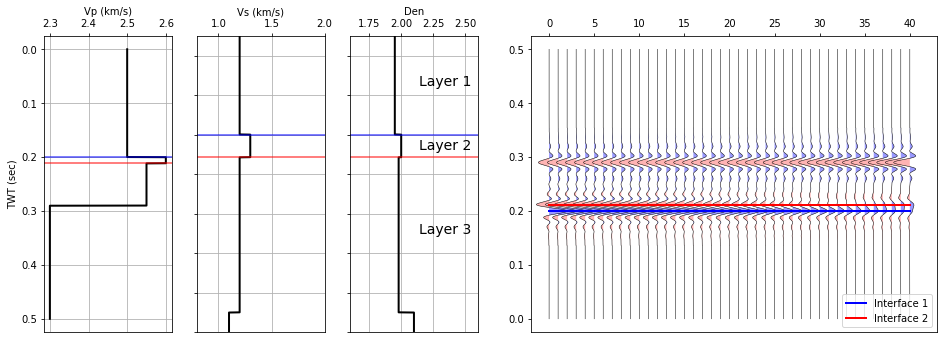

In [140]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nangles = int( (theta1_max-theta1_min)/theta1_step + 1)


#   Generate wavelet
if wvlt_type == 'ricker':
    wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)
    
elif wvlt_type == 'bandpass':
    wvlt_t, wvlt_amp = wvlt_bpass(f1, f2, f3, f4, wvlt_phase, dt, wvlt_length)

#   Apply amplitude scale factor to wavelet (to match seismic amplitude values)
wvlt_amp = wvlt_scalar * wvlt_amp

#   Calculate reflectivities from model parameters
rc_zoep_pp = []
theta1 = []
for i in range(0, nangles):
    theta1_buf = i*theta1_step + theta1_min
    rc_buf1 = rc_zoep(vp_mod[0], vs_mod[0], rho_mod[0], vp_mod[1], vs_mod[1], rho_mod[1], theta1_buf)
    rc_buf2 = rc_zoep(vp_mod[1], vs_mod[1], rho_mod[1], vp_mod[2], vs_mod[2], rho_mod[2], theta1_buf)
    rc_buf3 = rc_zoep(vp_mod[2], vs_mod[2], rho_mod[2], vp_mod[3], vs_mod[3], rho_mod[3], theta1_buf)
    
    
    theta1.append(theta1_buf)
    rc_zoep_pp.append([rc_buf1[0,0], rc_buf2[0,0], rc_buf3[0,0]])


#   Define time sample vector for output model & traces
nsamp = int((tmax-tmin)/dt) + 1
t = []
for i in range(0,nsamp):
    t.append(i*dt)


syn_zoep_pp = []
lyr_times = []
print("\n\nStarting synthetic calcuations...\n")
for angle in range(0, nangles):
    
    dz_app = thickness
    
    #   To calculate apparent thickness of layer 2 based on incidence angle
    #   uncomment the following three rows (e.g. ray-synthetics)
    #p = ray_param(vp_mod[0], angle)
    #angle2 = math.degrees(math.asin(p*vp_mod[1]))
    #dz_app = thickness/math.cos(math.radians(angle2))
    
    #   Calculate interface depths
    z_int = [500.0, 0, 0]
    for i in range(1,3):
        z_int[i] = z_int[i-1]+dz_app[i-1]
        #z_int.append(dz_app[i])
    #z_int.append(z_int + dz_app)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    rc = digitize_model(rc_zoep_pp[angle], t_int, t)

    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    #syn_buf = list(syn_buf)
    syn_zoep_pp.append(syn_buf)
    print("Calculated angle %i" % (angle))


#    Convert data arrays from lists/tuples to numpy arrays    
syn_zoep_pp = np.array(syn_zoep_pp)
rc_zoep_pp = np.array(rc_zoep_pp)
t = np.array(t)


#   Calculate array indicies corresponding to top/base interfaces
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')
lyr1_indx = list(lyr_indx[:,0])
lyr2_indx = list(lyr_indx[:,1])
lyr3_indx = list(lyr_indx[:,2])

#   Copy convolved top/base reflectivity values to Lists for easier plotting
[ntrc, nsamp] = syn_zoep_pp.shape
line1 = []
line2 = []
line3 = []
for i in range(0, ntrc):
    line1.append(syn_zoep_pp[i,lyr1_indx[i]])
    line2.append(syn_zoep_pp[i,lyr2_indx[i]])
    line3.append(syn_zoep_pp[i,lyr3_indx[i]])
    


#   AVO inversion for NI and GRAD from analytic and convolved reflectivity
#   values and print the results to the command line.  Linear least squares
#   method is used for estimating NI and GRAD coefficients.
Yzoep = np.array(rc_zoep_pp[:,0])
Yzoep = Yzoep.reshape((ntrc, 1))

Yconv = np.array(line1)
Yconv = Yconv.reshape((ntrc, 1))

ones = np.ones(ntrc)
ones = ones.reshape((ntrc,1))

sintheta2 = np.sin(np.radians(np.arange(0, ntrc)))**2
sintheta2 = sintheta2.reshape((ntrc, 1))

X = np.hstack((ones, sintheta2))

#   ... matrix solution of normal equations
Azoep = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yzoep)
Aconv = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Yconv)

print('\n\n')
print( '  Method       NI         GRAD')
print( '---------------------------------')
print( ' Zoeppritz%11.5f%12.5f' % (Azoep[0], Azoep[1]))
print( ' Convolved%10.5f%12.5f' % (Aconv[0], Aconv[1]))


    
#   Create a "digital" time domain version of the input property model for 
#   easy plotting and comparison with the time synthetic traces
vp_dig = np.zeros(t.shape)
vs_dig = np.zeros(t.shape)
rho_dig = np.zeros(t.shape)

vp_dig[0:lyr1_indx[0]] = vp_mod[0]
vp_dig[(lyr1_indx[0]):lyr2_indx[0]] = vp_mod[1]
vp_dig[(lyr2_indx[0]):] = vp_mod[2]
vp_dig[(lyr3_indx[0]):] = vp_mod[3]

vs_dig[0:lyr1_indx[0]] = vs_mod[0]
vs_dig[(lyr1_indx[0]):lyr2_indx[0]] = vs_mod[1]
vs_dig[(lyr2_indx[0]):] = vs_mod[2]
vs_dig[(lyr3_indx[0]):] = vs_mod[3]


rho_dig[0:lyr1_indx[0]] = rho_mod[0]
rho_dig[(lyr1_indx[0]):lyr2_indx[0]] = rho_mod[1]
rho_dig[(lyr2_indx[0]):] = rho_mod[2]
rho_dig[(lyr3_indx[0]):] = rho_mod[3]

#############################################
#
#       PLOTTING HAPPENS BELOW HERE
#


#   Create the plot figure
fig = plt.figure(figsize=(16, 12))
fig.set_facecolor('white')


#   Plot log curves in two-way time
ax0a = fig.add_subplot(261)
l_vp_dig, = ax0a.plot(vp_dig/1000, t, 'k', lw=2)
#ax0a.set_ylim((min_plot_time,max_plot_time))
#ax0a.set_xlim(1.5, 4.0)
ax0a.invert_yaxis()
ax0a.set_ylabel('TWT (sec)')
ax0a.xaxis.tick_top()
ax0a.xaxis.set_label_position('top')
ax0a.set_xlabel('Vp (km/s)')
ax0a.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0a.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0a.grid()

ax0b = fig.add_subplot(262)
l_vs_dig, = ax0b.plot(vs_dig/1000, t, 'k', lw=2)
ax0b.set_ylim((min_plot_time,max_plot_time))
ax0b.set_xlim((0.8, 2.0))
ax0b.invert_yaxis()
ax0b.xaxis.tick_top()
ax0b.xaxis.set_label_position('top')
ax0b.set_xlabel('Vs (km/s)')
ax0b.set_yticklabels('')
ax0b.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0b.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0b.grid()

ax0c = fig.add_subplot(263)
l_rho_dig, = ax0c.plot(rho_dig, t, 'k', lw=2)
ax0c.set_ylim((min_plot_time,max_plot_time))
ax0c.set_xlim((1.6, 2.6))
ax0c.invert_yaxis()
ax0c.xaxis.tick_top()
ax0c.xaxis.set_label_position('top')
ax0c.set_xlabel('Den')
ax0c.set_yticklabels('')
ax0c.axhline(lyr_times[0,0], color='blue', lw=2, alpha=0.5)
ax0c.axhline(lyr_times[0,1], color='red', lw=2, alpha=0.5)
ax0c.grid()

plt.text(2.55,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'Layer 1',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,1] + (lyr_times[0,0] - lyr_times[0,1])/2. + 0.002,
        'Layer 2',
        fontsize=14,
        horizontalalignment='right')
plt.text(2.55,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'Layer 3',
        fontsize=14,
        horizontalalignment='right')

#   Plot synthetic gather and model top & base interfaces in two-way time
ax1 = fig.add_subplot(222)
plot_vawig(ax1, syn_zoep_pp, t, excursion)
#ax1.set_ylim((min_plot_time,max_plot_time))
l_int1, = ax1.plot(lyr_times[:,0], color='blue', lw=2)
l_int2, = ax1.plot(lyr_times[:,1], color='red', lw=2)

plt.legend([l_int1,l_int2], ['Interface 1', 'Interface 2'], loc=4)
ax1.invert_yaxis()
label_str = 'Synthetic angle gather\nLayer 2 thickness = %4.1fm' % thickness
ax1.set_xlabel(label_str, fontsize=14)
ax1.set_ylabel('TWT (sec)')


#   Plot Zoeppritz and convolved reflectivity curves    
ax2 = fig.add_subplot(2,2,3)

l_syn1, = ax2.plot(line1, color='blue', linewidth=2)
l_rc1, = ax2.plot( rc_zoep_pp[:,0], '--', color='blue', lw=2)

ax2.set_xlim((-excursion, ntrc+excursion))
ax2.grid()
ax2.set_xlabel('Angle of incidence (deg)')
ax2.set_ylabel('Reflection coefficient')
ax2.set_title('Upper interface reflectivity')
plt.legend([l_syn1, l_rc1], ['Convolved', 'Zoepprtiz'], loc=0)

ax3 = fig.add_subplot(2,2,4)
l_syn2, = ax3.plot(line2, color='red', linewidth=2)
l_rc2, = ax3.plot( rc_zoep_pp[:,1], '--', color='red', lw=2)
#ax3.set_xlim((-excursion, ntrc+excursion))
ax3.grid()
ax3.set_xlabel('Angle of incidence (deg)')
ax3.set_ylabel('Reflection coefficient')
ax3.set_title('Lower interface reflectivity')
plt.legend([l_syn2, l_rc2], ['Convolved', 'Zoepprtiz'], loc=0)


#   Save the plot
#plt.savefig('figure_2.png')

#   Display the plot
plt.show()

In [ ]:
z_int

In [ ]:
t_int

In [ ]:
vp_dig.shape

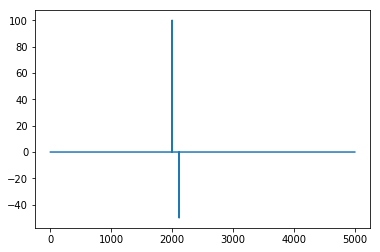

In [118]:
plt.plot(np.diff(vp_dig))

In [128]:
lyr_indx

array([[2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
       [2000, 2115, 2900],
 